In [1]:
!pip install datasets -q
!pip install transformers -q
!pip install sentencepiece -q

In [2]:
import numpy as np
import pandas as pd

# Stereoset Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset('stereoset', 'intersentence')

Generating validation split:   0%|          | 0/2123 [00:00<?, ? examples/s]

Dataset stereoset downloaded and prepared to /root/.cache/huggingface/datasets/stereoset/intersentence/1.0.0/b188e395e95b37c7a095ebc2de352fbdb249d67d1beb2ff639bb4dc37dfbb090. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['id', 'target', 'bias_type', 'context', 'sentences'],
        num_rows: 2123
    })
})

In [5]:
dataset['validation'][2:3]['sentences'][0]['sentence']

['The wind is blowing at 80 mph.',
 'She does not have to worry about child predators.',
 'She is a target for child predators.']

In [6]:
stereo_sentence = []
ster = dataset['validation'][0:]['bias_type']

for i in range(len(ster)):
    if ster[i] == 'gender':
        sent = dataset['validation'][i:i+1]['sentences'][0]['sentence']
        gold_label = dataset['validation'][i:i+1]['sentences'][0]['gold_label']
        for j in range(len(gold_label)):
            if gold_label[j] == 0:
                #print(sent[j])
                stereo_sentence.append(sent[j])

In [7]:
len(stereo_sentence)

242

In [8]:
stereo_sent1 = []
ster = dataset['validation'][0:]['bias_type']

for i in range(len(ster)):
    if ster[i] == 'gender':
        sent = dataset['validation'][i:i+1]['sentences'][0]['sentence']
        gold_label = dataset['validation'][i:i+1]['sentences'][0]['gold_label']
        for j in range(len(gold_label)):
            if gold_label[j] == 1:
                #print(sent[j])
                stereo_sent1.append(sent[j])

In [9]:
len(stereo_sent1)

242

In [10]:
stereo_sentence.append(stereo_sent1)

In [11]:
import pandas as pd

df1 = pd.DataFrame(stereo_sentence)

In [12]:
df2 = pd.Series([1 for x in range(len(df1.index))])

In [13]:
df = pd.concat([df1,df2],axis=1,ignore_index=False)

In [14]:
df.columns = ['data','stereotype']

In [15]:
df.head()

,data,stereotype
0,She does not have to worry about child predators.,1
1,She pulled a beer out of the fridge and leaned...,1
2,"She is a lazy, unkind person.",1
3,She thinks she will be in the top of her pilot...,1
4,she had blonde hair,1


# Load the data from G Drive(data.xlsx)

In [16]:
#Setup Gdrive file download extention 
!pip install gdown -q

In [17]:
!gdown  1zqzrHcpjqYl6Gkdgj9AGGyVlBbTL93pV

Downloading...
From: https://drive.google.com/uc?id=1zqzrHcpjqYl6Gkdgj9AGGyVlBbTL93pV
To: /kaggle/working/data.xlsx
100%|█████████████████████████████████████████| 699k/699k [00:00<00:00, 122MB/s]


In [18]:
poems_df = pd.read_excel('/kaggle/working/data.xlsx', sheet_name='poems')
# Read the 'rhymes' sheet from the Excel file
rhymes_df = pd.read_excel('/kaggle/working/data.xlsx', sheet_name='rhymes')
#poems_df['poem'] = poems_df['poem']+341
combined_df = pd.concat([rhymes_df, poems_df], ignore_index=True)
combined_df.shape

(13020, 4)

In [19]:
comb_df = combined_df.drop(columns=['aug_data','poem'])
comb_df.shape

(13020, 2)

In [20]:
combo = pd.concat([comb_df,df],ignore_index=False)
combo.head()

,data,stereotype
0,"Jack and Jill went up the hill, To fetch a pai...",0
1,"Jack fell down and broke his crown, And Jill c...",0
2,"Up Jack got, and home did trot, As fast as he ...",0
3,"He went to bed to mend his head, With vinegar ...",0
4,Jill came in And she did grin,0


In [21]:
# Avoid Printing Warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combo["data"], combo["stereotype"], test_size=0.30, random_state=42)

In [23]:
train_df = pd.concat([X_train,y_train],axis=1)
train_df.groupby(['stereotype']).count()

,data
stereotype,
0,8844
1,440


In [24]:
test_df = pd.concat([X_test,y_test],axis=1)
test_df.groupby(['stereotype']).count()

,data
stereotype,
0,3788
1,191


In [25]:
ls = []
idx = train_df.index.values
for i in idx:
  if combined_df[i:i+1]['stereotype'].values[0]==1:
    ls.append(combined_df[i:i+1][["aug_data",'stereotype']].values[0])

In [26]:
ls = pd.DataFrame(ls, columns=train_df.columns)
train_df2 = pd.concat([train_df,ls])
train_df2.groupby(['stereotype']).count()

,data
stereotype,
0,8844
1,740


In [27]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, RandomSampler, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [28]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoModel
import re
from transformers import BertTokenizer, BertForSequenceClassification
import sklearn

In [29]:
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("henryscheible/bert-base-uncased_stereoset_finetuned")
#choose appropriate model
model = BertForSequenceClassification.from_pretrained('henryscheible/bert-base-uncased_stereoset_finetuned',
                                                      num_labels=2)
model.to(device)

In [31]:
import random
seed_val=3407
torch.manual_seed(seed_val)
np.random.seed(seed_val)
random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [32]:
train_df2.stereotype.value_counts()

0    8844
1     740
Name: stereotype, dtype: int64

In [33]:
#maximum length of the sentence
max_len = 0
num_tokens = 0

# For every sentence...
for sent in train_df2.data:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    num_tokens += (len(input_ids)-2)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
print('The number of tokens: ', num_tokens)

Max sentence length:  62
The number of tokens:  92308


# Data Statistics

In [34]:
from sklearn.model_selection import train_test_split

#split original DataFrame into training and testing sets
#train, test_data = train_test_split(data, test_size=0.2, random_state=seed_val)
train_data, val_data = train_test_split(train_df2, test_size=0.1, random_state=seed_val)

In [35]:
test_data = pd.concat([X_test,y_test],axis=1)

In [36]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (8625, 2)
Validation data shape: (959, 2)
Test data shape: (3979, 2)


In [37]:
train_data.stereotype.value_counts()/train_data.stereotype.count()

0    0.92371
1    0.07629
Name: stereotype, dtype: float64

In [38]:
train_data.groupby(['stereotype']).count()

,data
stereotype,
0,7967
1,658


In [39]:
val_data.stereotype.value_counts()/val_data.stereotype.count()

0    0.914494
1    0.085506
Name: stereotype, dtype: float64

In [40]:
val_data.groupby(['stereotype']).count()

,data
stereotype,
0,877
1,82


In [41]:
test_data.stereotype.value_counts()/test_data.stereotype.count()

0    0.951998
1    0.048002
Name: stereotype, dtype: float64

In [42]:
test_data.groupby(['stereotype']).count()

,data
stereotype,
0,3788
1,191


# Bert Based Model Fine-tuned

In [43]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 75
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32

In [44]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.data.to_list()
        self.targets = dataframe.stereotype.to_list()
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index]) 
        text = " ".join(text.split())
        targets = self.targets[index]
        inputs = self.tokenizer.encode_plus(text,add_special_tokens=True,
                                            max_length=self.max_len,
                                            pad_to_max_length=True,
                                            return_token_type_ids=True,
                                            return_attention_mask=True)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(targets, dtype=torch.float)
               }

In [45]:
#create Sentiment Dataset
train_data_sent = SentimentData(train_data, tokenizer, MAX_LEN)
val_data_sent = SentimentData(val_data, tokenizer, MAX_LEN)
test_data_sent = SentimentData(test_data, tokenizer, MAX_LEN)

In [46]:
train_loader= DataLoader(train_data_sent,batch_size=TRAIN_BATCH_SIZE,shuffle=True)#sampler = RandomSampler(train_data_sent),
val_loader= DataLoader(val_data_sent, batch_size=TRAIN_BATCH_SIZE,shuffle=True)#,sampler = RandomSampler(val_data_sent),
test_loader = DataLoader(test_data_sent, batch_size=VALID_BATCH_SIZE)

In [47]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr = 5e-5, eps = 1e-8)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

540


In [49]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
    #cnf_mat = sklearn.metrics.confusion_matrix(labels_flat,pred_flat)
    return acc

In [50]:
def train_classifier(model,train_loader,val_loader,optimizer,epochs=4):
    print("Training...")
    training_stats = []
    for epoch in range(epochs):
        total_train_loss = 0
        total_train_acc = 0
        model.train()
        #load the batch
        for step, batch in tqdm(enumerate(train_loader,0)):#enumerate(train_loader)
            input_ids = batch['ids'].to(device, dtype = torch.long)
            input_mask = batch['mask'].to(device, dtype = torch.long)
            input_token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            input_targets = batch['targets'].to(device, dtype = torch.long)
            #outputs = model(ids, mask, token_type_ids).squeeze()
            #loss = loss_function(outputs, targets)
            
            optimizer.zero_grad()
            outputs = model(input_ids, token_type_ids=None,attention_mask=input_mask,
                             labels=input_targets)
            loss = outputs.loss
            total_train_loss += loss.item()
            logits = outputs.logits
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = input_targets.to('cpu').numpy()
            total_train_acc += flat_accuracy(logits, label_ids)
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            # Update the learning rate.
            scheduler.step()
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Average training loss: {avg_train_loss: 0.2f}")
        avg_train_acc = total_train_acc / len(train_loader)
        print(f"The training accuracy for the epoch {epoch} is {avg_train_acc}")

        print("*****")
        print("Validation...!!")
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for _,batch in tqdm(enumerate(val_loader,0)):
            val_ids = batch['ids'].to(device, dtype = torch.long)
            val_mask = batch['mask'].to(device, dtype = torch.long)
            val_token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            val_targets = batch['targets'].to(device, dtype = torch.long)
            with torch.no_grad(): 
                val_out = model(val_ids,token_type_ids=None,
                                attention_mask=val_mask,labels=val_targets)
                loss = val_out.loss
                logits = val_out.logits
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = val_targets.to('cpu').numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids) 

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(val_loader)
        print("Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(val_loader)

        print("Validation Loss: {0:.2f}".format(avg_val_loss))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                "Train. Accur.": avg_train_acc,
                'Valid. Accur.': avg_val_accuracy
            })            
    print("Training Complete!!")
    return training_stats

In [51]:
#train the model and collect the statistics
stats = train_classifier(model,train_loader,val_loader,optimizer)

Training...


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
135it [01:01,  2.19it/s]


Average training loss:  0.19
The training accuracy for the epoch 0 is 0.9343041383219954
*****
Validation...!!


15it [00:02,  6.35it/s]


Accuracy: 0.96
Validation Loss: 0.11


135it [01:00,  2.24it/s]


Average training loss:  0.06
The training accuracy for the epoch 1 is 0.9817932728647014
*****
Validation...!!


15it [00:02,  6.27it/s]


Accuracy: 0.97
Validation Loss: 0.11


135it [01:00,  2.24it/s]


Average training loss:  0.02
The training accuracy for the epoch 2 is 0.9951034580498866
*****
Validation...!!


15it [00:02,  6.36it/s]


Accuracy: 0.97
Validation Loss: 0.11


135it [01:00,  2.24it/s]


Average training loss:  0.01
The training accuracy for the epoch 3 is 0.9974537037037037
*****
Validation...!!


15it [00:02,  6.34it/s]

Accuracy: 0.97
Validation Loss: 0.12
Training Complete!!


In [52]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Train. Accur.,Valid. Accur.
epoch,,,,
1,0.19,0.11,0.93,0.96
2,0.06,0.11,0.98,0.97
3,0.02,0.11,1.00,0.97
4,0.01,0.12,1.00,0.97


In [53]:
#eval function
def eval_model(model,loader):
    print("Evaluation...!!")
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    preds = []
    labels = []
    # Evaluate data for one epoch
    for _,batch in tqdm(enumerate(loader,0)):
        val_ids = batch['ids'].to(device, dtype = torch.long)
        val_mask = batch['mask'].to(device, dtype = torch.long)
        val_token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
        val_targets = batch['targets'].to(device, dtype = torch.long)
        with torch.no_grad(): 
            val_out = model(val_ids,token_type_ids=None,
                                attention_mask=val_mask,labels=val_targets)
            loss = val_out.loss
            logits = val_out.logits
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = val_targets.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids) 
            preds.extend(np.argmax(logits, axis=1).flatten())
            labels.extend(label_ids.flatten())

        # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(loader)
    print("Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(loader)

    print("Test Loss: {0:.2f}".format(avg_val_loss))
    df = pd.DataFrame({'labels': labels, 'Preds': preds}) 
    print("Evaluation Complete!!")
    return df

In [54]:
#evaluate the model and collect the outputs, labels and IPO_label
df = eval_model(model, test_loader)

Evaluation...!!


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
125it [00:11, 10.97it/s]

Accuracy: 0.97
Test Loss: 0.14
Evaluation Complete!!


In [55]:
# performormance metrics
#load the packages for Analysis
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score

In [56]:
#some wrapper functions
def results_analysis(df):
    acc = accuracy_score(df.labels,df.Preds)
    print(f'The accuracy is {acc}')
    precision, recall, fscore, support = score(df.labels, df.Preds)
    results_df = pd.DataFrame({'precision':precision,'recall':recall,
                            'fscore':fscore,'support':support})
    display(results_df)
    
def cnf_matrix(df):
    #np.set_printoptions(precision=4)
    mat = confusion_matrix(df.labels,df.Preds)
    df_cm = pd.DataFrame(mat, range(2), range(2))
    sns.heatmap(df_cm,annot=True, fmt="d")
    plt.show()

In [57]:
results_analysis(df)

The accuracy is 0.9668258356370948


,precision,recall,fscore,support
0,0.98,0.98,0.98,3788
1,0.67,0.62,0.64,191


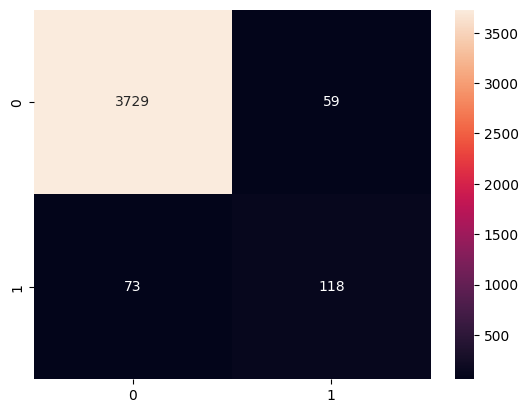

In [58]:
cnf_matrix(df)